# Traub Miles (SNL) Bifurcation Graph Explained from scratch

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/path2auto/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil


In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
#     for k in range(2):
#         ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [6]:
from matplotlib.patches import Polygon
def zoomingPoly(ax1, roi, ax2, color='red', linewidth=2, dy=0,roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
#     ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    ax1.add_patch(Polygon([(roi[0],roi[2]),(roi[1],roi[2]+dy),(roi[1],roi[3]+dy),(roi[0],roi[3]),(roi[0],roi[2])], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]

# np.array([t_I_app_specf[ii_iapi]-0.25,t_I_app_specf[ii_iapi]+0.25,min(v_saddle_point[ii_api_ss])-60,max(v_one_sim[ii_api_lc][0])+5]), ax[ii_iapi],color='grey')

# Polygon([(roi[0],roi[2]),(roi[1],roi[2]+dy),(roi[1],roi[3]+dy),(roi[0],roi[2])])

# poly = Polygon([(0, 0), (0, 2), (1, 1),
#     (2, 2), (2, 0), (1, 0.8), (0, 0)])
# x,y = poly.exterior.xy

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_Jacobian(neuron_snap,bifpar):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    return(J)

In [8]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

In [9]:
# Function to adjust Jmat dimensions
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat

In [10]:
import re

def get_floquet_mults_from_fortDot9():
    ##### Writes the floquet multipliers calculated in AUTO in a directory
    ### After running a continuation, extract multipliers from file fort.9
    ## and store them in a directory
    ## Make sure the file exists....
    # This was done fast.. maybe can be simplified with split....
    result = {}
    result['PT']={}
    mult_regex0 = r"""-?\d+\s+(\d+)\s+Multipliers:\s+Stable:\s+(\d+)"""
    mult_regex1 = r"""-?\d+\s+(\d+)\s+Multiplier\s+(\d+)\s+(\S+)"""
    with open('fort.9', 'r') as f:
        for line in f:
            if 'Multipliers' in line:
                line_match = re.search(mult_regex0, line)
                if line_match is None:
                    continue
                if line_match.group(1) is not None:
                    result['PT'][line_match.group(1)] = {}
                    result['PT'][line_match.group(1)]["stable"] = int(line_match.group(2))
                    result['PT'][line_match.group(1)]['Floquet_Multipliers']=[]
            else:
                line_match = re.search(mult_regex1, line)
                if line_match is None:
                    continue
                if line_match.group(1) is not None:
                    result['PT'][line_match.group(1)]['Floquet_Multipliers'].append(float(line_match.group(3)))
                    
    return result

In [11]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [12]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False,tight=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        if tight:
            ax.savefig(fig_name+'.png',dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf",dpi=rast, bbox_inches = 'tight',
    pad_inches = 0)
        else:
            ax.savefig(fig_name+'.png',dpi=rast)
            fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        if tight:
            ax.savefig(fig_name+'.png', bbox_inches = 'tight',
    pad_inches = 0)
            fig.savefig(pdffig, format="pdf", bbox_inches = 'tight',
    pad_inches = 0)

        else:
            ax.savefig(fig_name+'.png')
            fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

# Defining setup for the continuations

### Defining neuron model

In [13]:
## Loading neuron model (file in the cfg folder)
model_name='MTM_W_sPNAs_Temp_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name+'.json',strIapp=strIapp)


### Defining bifurcation parameters


In [ ]:
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
I_app=-20.0
K_o=14.0
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o

In [ ]:
### Using the function above to obtain the expressions from the model (needed to run AUTO)
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


# Running AUTO (to continue on the bifpar space)

### Continuing the ss forward to find the saddle node and the hopf bifurcations

In [ ]:
import autoutils
import auto
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app
    r1_fwd= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
        UZSTOP= {})

## Making sure the original path is restored
os.chdir(cwd_nonTemp)
###### HEre we store the continuation in np arrays vectors
v_s_par=[strIapp]

v_s_var=[]
for i in range(len(unames)):
    v_s_var.append(unames[i+1])

m_res_par=[]
for i_s in v_s_par:
    m_res_par.append(r1_fwd[i_s])

m_res_statev=[]
for i_s in v_s_var:
        m_res_statev.append(r1_fwd[i_s])

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -20.0, 2: 14.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -9.68747E+00   1.44887E+02  -1.44883E+02   5.65183E-09   1.19533E-10   1.00000E+00
   1  8060  LP    3  -1.55395E+00   6.47225E+01  -6.47149E+01   5.41638E-02   2.33616E-02   9.92746E-01
   1     2        4  -1.65951E+01   5.57002E+01  -5.56920E+01   1.82643E-01   1.13

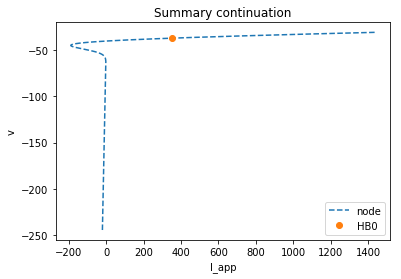

In [ ]:
## Summary continuation..
plt.plot(m_res_par[0],m_res_statev[v_s_var=='v'],'--',label='node')
plt.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'o',label='HB0')
# plt.plot(r1_fwd.getLabel('HB')[1][strIapp],r1_fwd.getLabel('HB')[1]['v'],'o',label='HB1')
plt.xlabel(strIapp)
plt.ylabel(v_s_var[v_s_var=='v'])
plt.title('Summary continuation')
plt.legend()

In [ ]:
### Extracting current for initiation of regular spiking, and for depolarization block
s0HB = r1_fwd('HB')[0]
# s1HB = r1_fwd('HB')[1]

### Continuing the hopf point backwards to find the limit cycle onset (period>>0).

In [ ]:
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_b = auto.run(s0HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1, NTST= 300,
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100})
    r1_period0_f = auto.run(s0HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=1e-2, DSMIN=1e-3, DSMAX=1e-1, NTST= 300,
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100})
    
    r1_period0=r1_period0_b+r1_period0_f
        
os.chdir(cwd_nonTemp)
############ Extracting info from AUTO object
#############################################################
##### Finding limit cycle onset (period>>0)
try:
    lc_onset = r1_period0.getLabel('LP')[0]
except:
    try:
        lc_onset = r1_period0.getLabel('UZ')[0]
    except:
        pass
    pass


###### HEre we extract the information AUTO calculated and store it in numpy arrays     
m_res_par_lc=[]
for i_s in v_s_par:
    m_res_par_lc.append(r1_period0[i_s])

m_res_statev_lc=[]
for i_s in v_s_var:
    m_res_statev_lc.append(r1_period0['MAX '+i_s])


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -20.0, 2: 14.0, 11: 0}
For fix point continuation AUTO requires:
2=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  13     3  BP   25   3.51671E+02   3.74644E+01  -3.74391E+01   6.16183E-01   6.17401E-01   1.26609E-01   1.28116E+00
  13  3000       26   5.29576E+01   4.67339E+01  -8.21393E-02   6.07358E-01   9.77926E-01   2.55212E-01   1.81088E+00
  13  3847  LP   27  -2.35230E+00   6.06

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  13  3000       25   5.29555E+01   4.67341E+01  -8.14228E-02   6.07359E-01   9.77927E-01   2.55216E-01   1.81090E+00
  13  3845  LP   26  -2.35230E+00   6.06737E+01   5.78933E+01   6.82342E-01   9.99708E-01   9.81563E-01   7.62008E+01
  13  3858  UZ   27  -2.35230E+00   6.07577E+01   5.78926E+01   6.82343E-01   9.99708E-01   9.81563E-01   1.00001E+02

 Total Time    0.651E+01
autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


(-200, 500)

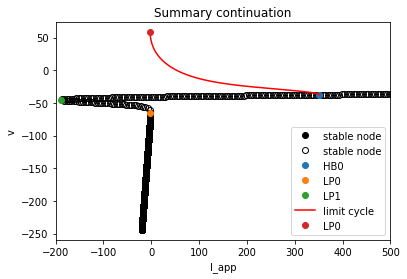

In [ ]:
## Summary continuation..
dtsbif=500
plt.plot(m_res_par[0][m_res_statev[v_s_var=='v']<float(r1_fwd.getLabel('LP')[0]['v'])],m_res_statev[v_s_var=='v'][m_res_statev[v_s_var=='v']<float(r1_fwd.getLabel('LP')[0]['v'])],'o',color='k',label='stable node')
plt.plot(m_res_par[0][m_res_statev[v_s_var=='v']>float(r1_fwd.getLabel('LP')[0]['v'])][::dtsbif],m_res_statev[v_s_var=='v'][m_res_statev[v_s_var=='v']>float(r1_fwd.getLabel('LP')[0]['v'])][::dtsbif],'o',mfc='none',color='k',label='stable node')



plt.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'o',label='HB0')
plt.plot(r1_fwd.getLabel('LP')[0][strIapp],r1_fwd.getLabel('LP')[0]['v'],'o',label='LP0')
plt.plot(r1_fwd.getLabel('LP')[1][strIapp],r1_fwd.getLabel('LP')[1]['v'],'o',label='LP1')
## stable Limit cycle
plt.plot(m_res_par_lc[0],m_res_statev_lc[v_s_var=='v'],color='r',label='limit cycle')

plt.legend()

plt.plot(r1_period0.getLabel('UZ')[0][strIapp],r1_period0.getLabel('UZ')[0]['MAX v'],'o',label='LP0')
plt.xlabel(strIapp)
plt.ylabel(v_s_var[v_s_var=='v'])
plt.title('Summary continuation')
plt.legend()
plt.xlim([-200,500])


In [ ]:
### Extracting limit cycle onset
lc=r1_period0.getLabel('UZ')[0]
sn=r1_fwd.getLabel('LP')[0]

# Finding phase planes for different I_apps

In [ ]:
##############################################3
### Finding phase planes in the spiking and stable region
I_app=-30


## Applied currents for which we want to get the phase planes
t_I_app_specf=[r1_fwd.getLabel('LP')[0][strIapp]-5,lc[strIapp]-2,lc[strIapp]+0.1,sn[strIapp]-0.01,lc[strIapp]+10]
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf_f= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    r1_fwd_sn_I_app_specf_b= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= -1 * 1e-3, DSMAX= -1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
    r1_fwd_sn_I_app_specf=r1_fwd_sn_I_app_specf_f+r1_fwd_sn_I_app_specf_b
    
os.chdir(cwd_nonTemp)

s1HB = r1_fwd_sn_I_app_specf('HB')[0]
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    r1_period0_I_app_specf_00 = auto.run(s0HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1, NTST= 300,UZR= {strIapp: [s0HB[strIapp]-10]},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,strIapp: lc[strIapp]})
        
    r1_period0_I_app_specf = auto.run(r1_period0_I_app_specf_00.getLabel('UZ')[0], e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'],ISP=3, ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-3, DSMIN=-1e-4, DSMAX=-1e-2,UZR= {strIapp: np.array(t_I_app_specf)[np.array(t_I_app_specf)>lc[strIapp]]},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,strIapp: lc[strIapp]-0.1})
    
    
    d_Floq_Mults_Iapp_Specf=get_floquet_mults_from_fortDot9()
    
    
    
os.chdir(cwd_nonTemp)

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -1.96875E+01   2.41957E+02  -2.41955E+02   3.77908E-18   3.91470E-21   1.00000E+00
   1     2        3  -9.37143E+00   1.42492E+02  -1.42489E+02   9.43675E-09   2.16161E-10   1.00000E+00
   1  2734  UZ    4  -6.55395E+00   1.15327E+02  -1.15323E+02   2.98087E-06   1.74374E-07   1.00000E+00
   1  4869  UZ    5  -4.35230E+00   9.41002E+01  -9.40949E+01   2.35146E-04   3.02798E-05   9.99996E-01
   1  6906  UZ    6  -2.25230E+00   7.38475E+01  -7.38408E+01   1.16410E-02   3.40626E-03   9.99291E-01
   1  7629  UZ    7  -1.56395E+00   6.66599E+01  -6.66525E+01   3.98785E-02   1.58

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -30, 11: 0}
For fix point continuation AUTO requires:
1=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNAs_Temp_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  13     3  LP   25   3.76071E+02   3.74866E+01  -3.74699E+01   6.15720E-01   6.16526E-01   1.27157E-01   1.26411E+00
  13     5  BP   26   3.76070E+02   3.74866E+01  -3.74506E+01   6.15788E-01   6.17032E-01   1.27215E-01   1.26411E+00
  13   353  UZ   27   3.41672E+02   3.81382E+01  -3

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  13  3000       31   3.11739E+02   3.87307E+01  -3.07135E+01   6.21601E-01   7.66557E-01   1.45296E-01   1.28829E+00
  13  6000       32   2.81764E+02   3.93546E+01  -2.89001E+01   6.18805E-01   7.97019E-01   1.49859E-01   1.30347E+00
  13  9000       33   2.51787E+02   4.00178E+01  -2.70842E+01   6.15347E-01   8.23819E-01   1.54570E-01   1.32233E+00
  13  2001       34   2.21810E+02   4.07324E+01  -2.51117E+01   6.11533E-01   8.48986E-01   1.59952E-01   1.34620E+00
  13  5001       35   1.91837E+02   4.15152E+01  -2.28360E+01   6.07654E-01   8.73716E-01   1.66589E-01   1.37717E+00
  13  8001       36   1.61869E+02   4.23912E+01  -2.00606E+01   6.04116E-01   8.98742E-01   1.75392E-01   1.41865E+00
  13  1002       37   1.31913E+02   4.33994E+01  -1.64387E+01   6.01547E-01   9.24262E-01   1.87966E-01   1.47656E+00
  13  4002       38   1.01979E+02   4.46045E+01  -1.14410E+01   6.00906E-01   9.48975E-01   2.06956E-01   1.56164E+00
  13  7002       39   7.20862E+01   4.61223E+01  -4.2372

  13  6985  LP  101  -1.91830E+00   6.10747E+01   5.79832E+01   6.80464E-01   9.99707E-01   9.84457E-01   4.25608E+01
  13  6991  LP  102  -1.91579E+00   6.10853E+01   5.72565E+01   6.80482E-01   9.99715E-01   9.84497E-01   4.28989E+01
  13  7000  LP  103  -1.91655E+00   6.10993E+01   5.79538E+01   6.80453E-01   9.99652E-01   9.84507E-01   4.38807E+01
  13  7028  LP  104  -1.91846E+00   6.11343E+01   5.78469E+01   6.80592E-01   9.99712E-01   9.84552E-01   4.66835E+01
  13  7030  LP  105  -1.91517E+00   6.11418E+01   5.76296E+01   6.80256E-01   9.99701E-01   9.84583E-01   4.66579E+01
  13  7039  LP  106  -1.91619E+00   6.11513E+01   5.74643E+01   6.80374E-01   9.99707E-01   9.84571E-01   4.75508E+01
  13  7042  LP  107  -1.91818E+00   6.11488E+01   5.78159E+01   6.80162E-01   9.99695E-01   9.84568E-01   4.76798E+01
  13  7045  LP  108  -1.91627E+00   6.11492E+01   5.79919E+01   6.80395E-01   9.99702E-01   9.84587E-01   4.74650E+01
  13  7075  BP  109  -1.91159E+00   6.12465E+01   5.7850

  13  7495  LP  171  -1.91609E+00   6.07408E+01   5.76479E+01   6.80488E-01   9.99677E-01   9.82781E-01   2.85194E+01
  13  7498  LP  172  -1.91654E+00   6.07366E+01   5.78588E+01   6.80398E-01   9.99706E-01   9.82751E-01   2.84297E+01
  13  7504  LP  173  -1.91599E+00   6.07319E+01   5.78197E+01   6.80349E-01   9.99703E-01   9.82697E-01   2.82700E+01
  13  7507  LP  174  -1.91685E+00   6.07277E+01   5.79319E+01   6.80513E-01   9.99707E-01   9.82669E-01   2.82032E+01
  13  7511  LP  175  -1.91603E+00   6.07255E+01   5.76261E+01   6.80564E-01   9.99652E-01   9.82633E-01   2.80814E+01
  13  7516  LP  176  -1.91654E+00   6.07175E+01   5.75990E+01   6.80572E-01   9.99667E-01   9.82571E-01   2.79145E+01
  13  7522  LP  177  -1.91565E+00   6.07105E+01   5.78719E+01   6.80129E-01   9.99696E-01   9.82501E-01   2.76765E+01
  13  7540  LP  178  -1.91638E+00   6.06855E+01   5.76184E+01   6.80321E-01   9.99700E-01   9.82265E-01   2.70839E+01
  13  7549  LP  179  -1.91664E+00   6.06739E+01   5.7781

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [ ]:
## Extracting all the steady states and limit cycle onsets for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')

In [ ]:
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(neuron_snap,bifpar,autobifpart)

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [ ]:
from sympy.utilities.lambdify import lambdify
from numpy import linalg as LA
## Extracting information from auto objects into numpy arrays
# Limit cycles
v_I_app=[]
v_one_sim_s=[]
v_one_sim=[]
v_Jeival_lc=[]
v_Jeivect_lc=[]
v_tau_lc=[]

v_stab_lc=[]
v_floquet_mult=[]

for lc_Iapp_specfi in lc_Iapp_specf:
    ddi={}
    one_sim=[]
    one_sim_s=[]
    v_s_par_ssi=[(k,v) for k,v in lc_Iapp_specfi.PAR.items()]
    lc_point0=[]
    lc_v=[]
    for i_s in lc_Iapp_specfi.coordnames:
        one_sim.append(lc_Iapp_specfi[i_s])
        one_sim_s.append(i_s)

    v_I_app.append(lc_Iapp_specfi.PAR[strIapp])
    v_one_sim_s.append(one_sim_s)
    v_one_sim.append(one_sim)
    v_tau_lc.append(lc_Iapp_specfi['period'])
    ##### Stability of limit cycle from floquet multipliers
    ddi=d_Floq_Mults_Iapp_Specf['PT'][str(lc_Iapp_specfi['PT'])]
    if ddi['stable']==len(ddi['Floquet_Multipliers']):
        v_stab_lc.append(1)
    else:
        v_stab_lc.append(0)
        
    v_floquet_mult.append(ddi['Floquet_Multipliers'])
    

In [ ]:
## Extracting information from auto objects into numpy arrays
# steady states
v_Jeival=[]
v_Jeivect=[]
v_saddle_point=[]
v_I_app_ss=[]
for ao_saddle_point in ss_I_app_specf:
    ### Getting position
    saddle_point=ao_saddle_point.coordarray
    ### Getting expressions of Jacobian for the parameters of each ss_I_app_specf
    bifpar[strIapp] = [str(ao_saddle_point.PAR[strIapp])+"* uA/cm2"]
    J = get_Jacobian(neuron_snap,bifpar)
    v_s_par_ssi=[(k,v) for k,v in ao_saddle_point.PAR.items()]
    J = [[j.subs(v_s_par_ssi) for j in k] for k in J]
    Jfoo = lambdify(ao_saddle_point.coordnames,J)
    Jmat=Jfoo(*saddle_point)
    m_JMat=fixing_jmat(Jmat)
    Jeival, Jeivect = LA.eig(m_JMat)
    v_saddle_point.append(saddle_point)
    v_Jeival.append(Jeival)
    v_Jeivect.append(Jeivect)
    v_I_app_ss.append(ao_saddle_point.PAR[strIapp])

In [ ]:
#### This is the format for the figures in the thesis
from matplotlib.pylab import *

import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

stable limit cycle
-1.5639464195
stable limit cycle
-1.5639464195
stable limit cycle
7.6477025842
stable limit cycle
7.6477025842


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


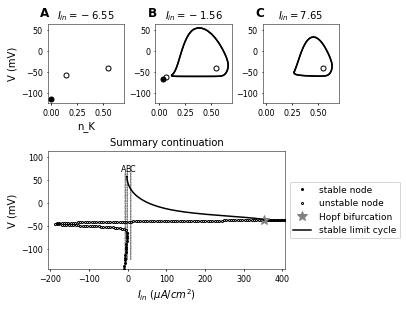

<Figure size 410.4x360 with 0 Axes>

In [ ]:
#### Drawing phase planes relative to bif diagram
import string
from matplotlib.pylab import *


# t_I_app_specf_temp_ii=range(len(t_I_app_specf))
t_I_app_specf_temp_ii=[0,3,4]
t_I_app_specf_temp=np.array(t_I_app_specf)[t_I_app_specf_temp_ii]
n_splts=len(t_I_app_specf_temp)


plt.close("all")

n_splts=len(t_I_app_specf_temp)


fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.9))
        
ax=[]
for ii_iapi in range(len(t_I_app_specf_temp[::int(len(t_I_app_specf_temp)/n_splts)])):
    if ii_iapi>0:
        ax.append(plt.subplot2grid((62,4*(n_splts)), (0, ii_iapi*4), colspan=3,rowspan=20,sharex=ax[0],sharey=ax[0]))
    else:
        ax.append(plt.subplot2grid((62,4*(n_splts)), (0, ii_iapi*4), colspan=3,rowspan=20))



## Summary continuation..
axpl = plt.subplot2grid((62,4*(n_splts)), (32, 0), colspan=9,rowspan=34)

resol_cont=600


axpl.plot(m_res_par[0][m_res_statev[v_s_var=='v']<float(r1_fwd.getLabel('LP')[0]['v'])][::resol_cont],m_res_statev[v_s_var=='v'][m_res_statev[v_s_var=='v']<float(r1_fwd.getLabel('LP')[0]['v'])][::resol_cont],'o',markersize=2,color='k',label='stable node',rasterized=True)
axpl.plot(m_res_par[0][m_res_statev[v_s_var=='v']>float(r1_fwd.getLabel('LP')[0]['v'])][::resol_cont],m_res_statev[v_s_var=='v'][m_res_statev[v_s_var=='v']>float(r1_fwd.getLabel('LP')[0]['v'])][::resol_cont],'o',markersize=2,color='k',mfc='none',label='unstable node',rasterized=True)
axpl.plot(m_res_par[0][m_res_par[0]>float(r1_fwd.getLabel('HB')[0][strIapp])][::resol_cont],m_res_statev[v_s_var=='v'][m_res_par[0]>float(r1_fwd.getLabel('HB')[0][strIapp])][::resol_cont],'o',markersize=2,color='k',rasterized=True)

axpl.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'*',markersize=10,color='grey',label='Hopf bifurcation')
axpl.plot(m_res_par_lc[0],m_res_statev_lc[v_s_var=='v'], color='k',label='stable limit cycle',rasterized=True)




axpl.set_xlabel(r'$I_{in}$ $(\mu A/cm^2)$')
axpl.set_ylabel('V (mV)')
axpl.set_title('Summary continuation')
axpl.legend(loc='center left', bbox_to_anchor=(1, 0.5))


s_x=0;s_y=1

###### Phase planes
v_saddle=[]
v_stable=[]
v_st_limit_cycle=[]
v_uns_limit_cycle=[]
v_st_tau_lc=[]
v_uns_tau_lc=[]
v_eig_focus=[]
for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    saddle=[]
    stable=[]
    st_limit_cycle=[]
    uns_limit_cycle=[]
    st_tau_lc=[]
    uns_tau_lc=[]
    eig_focus=[]
    ### Plot limit cycle onset
    ax[ii_iapi_ax].set_title(r'$I_{in}'+' = '+ str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$')
    st_lc=[]
    us_lc=[]
    for ii_api_lc in range(len(v_I_app)):
        if abs(v_I_app[ii_api_lc]-t_I_app_specf[ii_iapi])<1*10**-5:
            unst_lc=0            
            try:
                if v_stab_lc[ii_api_lc]==0:# and len(us_lc)==0: 
                    ax[ii_iapi_ax].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],'--',color='black')
                    uns_limit_cycle=v_one_sim[ii_api_lc]
                    uns_tau_lc=v_tau_lc[ii_api_lc]
                    uns_floquet=v_floquet_mult[ii_api_lc]
                    us_lc.append(ii_api_lc)
                    print('unstable limit cycle')
                    print(str(t_I_app_specf[ii_iapi]))
                elif v_stab_lc[ii_api_lc]==1:# and len(st_lc)==0:
                    ax[ii_iapi_ax].plot(v_one_sim[ii_api_lc][1],v_one_sim[ii_api_lc][0],color='black')
                    st_limit_cycle=v_one_sim[ii_api_lc]
                    st_tau_lc=v_tau_lc[ii_api_lc]
                    st_floquet=v_floquet_mult[ii_api_lc]
                    st_lc.append(ii_api_lc)
                    print('stable limit cycle')
                    print(str(t_I_app_specf[ii_iapi]))
            except:
                pass
    ### Plot ss
    for ii_api_ss in range(len(v_I_app_ss)):
        if abs(v_I_app_ss[ii_api_ss]-t_I_app_specf[ii_iapi])<0.1:
            if any(v_Jeival[ii_api_ss].real>0):
                ax[ii_iapi_ax].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,mfc='none',color='black')
                saddle=v_saddle_point[ii_api_ss]
            else:
                ax[ii_iapi_ax].plot(v_saddle_point[ii_api_ss][1],v_saddle_point[ii_api_ss][0],'o',markersize=5,color='black')
                stable=v_saddle_point[ii_api_ss]
                eig_focus=v_Jeival[ii_api_ss]
                

    axpl.text(t_I_app_specf[ii_iapi]+4.0+(ii_iapi)*2,max(v_one_sim[ii_api_lc][0])+52,string.ascii_uppercase[ii_iapi_ax],{'fontsize':matplotlib.rcParams["font.size"]-4}, va="top", ha="right")


ax[0].set_xlabel(v_one_sim_s[0][1])
ax[0].set_ylabel('V (mV)')


for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    yaxses=ax[ii_iapi_ax].get_ylim()
    zoomingPoly(axpl, np.array([t_I_app_specf[ii_iapi]-0.25,t_I_app_specf[ii_iapi]+0.25,yaxses[0],yaxses[1]]), ax[ii_iapi_ax],dy=5,linewidth=1,color='grey')

    
for n, axs in enumerate(ax):   
    axs.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
            size=matplotlib.rcParams["font.size"], weight='bold')
    
    
axpl.set_xlim(t_I_app_specf_temp[0]-200,t_I_app_specf_temp[-1]+400)
axpl.set_ylim(yaxses[0]-20,yaxses[1]+50)

    
fig_name='fig_SummaryContinuation_SNL_'+model_name

md_dir={}
md_dir['Title']='Summary continuation Iin for '+model_name+' and pase planes for applied current '+str(t_I_app_specf_temp)
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


plt.show()

In [ ]:
### run some simulations to find how the initial conditions don't determine the steady state
import sympy, scipy, brian2, matplotlib, brianutils
from brianutils import units
dir_sims_ISI='/groups/susanne/Data_Simulations/stochastic_bursting/'


sigma_v=[0.0,0,0,0]
v_vini=[-80.0,-80.0,80.0,80.0,20.0,7.073]
n_nini=[0.01,0.8,0.01,0.8,0.5,0.425]

num_neurons=len(v_vini) ## number of initial conditions to check out..

for ii_iapi in range(len(t_I_app_specf)):
    I_app=t_I_app_specf[ii_iapi]
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
    if os.path.isfile(dir_sims_ISI+name+'.pkl'):
        print(':) File: '+name+' '+str(ii_iapi)+'/'+str(len(t_I_app_specf)))
    else:
        print('calculating: '+name+' ')
        M= json.load(open("cfg/"+model_name+".json"))
        M['parameters'].update(bifpar)
        M['parameters'][strIapp]=M['parameters'][strIapp][0]
        M["definitions"][strIapp] = "("+strIapp+"i - sig*xi)"
        M["parameters"].pop(strIapp)
        M["parameters"][strIapp+"i"]=str(I_app)+"* uA/cm2"
        M["parameters"]["sig"]=str(sigma_v[0])+"*(uA/cm2*(ms)**.5)"
        sde0= brianutils.load_model(M)
        brian2.defaultclock.dt=eval("0.001 * ms", units)
        neurons= brian2.NeuronGroup(num_neurons, model=sde0, method="heun",
            threshold="v>-10*mV", refractory="2.5*ms", namespace=units)
        ## INIT STATES ##
        for k in sde0.diff_eq_names:
            if k is not "v":
                setattr(neurons,k,0.25)

        vu= eval("1*mV",units)
        neurons.v=np.array(v_vini)*vu
        neurons.n_K=np.array(n_nini)
        spikes = brian2.SpikeMonitor(neurons)
        states=brian2.StateMonitor(neurons,sde0.diff_eq_names,record=True,dt=eval("0.01*ms",units))
        networkx= brian2.Network( neurons, spikes,states) # , states
        #### Running simulation in brian
        networkx.run(eval("5*second",units))
        #### storing simulation results in matrix and saving
        s_results=[]
        v_results=[]
        for k in v_one_sim_s[0]:
            s_results.append(k)
            if k is not "v":
                v_results.append(getattr(states,k))
            else:
                v_results.append(getattr(states,k)/brian2.mV)
                
        s_results.append('t')
        v_results.append(getattr(states,'t')/brian2.ms)
        v_results=np.array(v_results)
        spikes_a=[]   
        for inneurons in range(num_neurons):
            spikes_t=spikes.t[spikes.i==inneurons]/brian2.ms
            spikes_a.append(spikes_t)


        #### Saving simulation
        d_save_sim={}
        d_save_sim['s_results']=s_results
        d_save_sim['v_results']=v_results
        d_save_sim['spikes']=spikes_a
        d_save_sim['Dyn_Sys_Properties']={}
        d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']=v_st_limit_cycle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']=v_uns_limit_cycle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']=v_st_tau_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']=v_uns_tau_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable_floquetMult_lc']=v_st_FloquetMult_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['unstable_floquetMult_lc']=v_uns_FloquetMult_lc[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['saddle']=v_saddle[ii_iapi]
        d_save_sim['Dyn_Sys_Properties']['stable']=v_stable[ii_iapi]
        d_save_sim['pars']=M["parameters"]
        save_obj(d_save_sim, dir_sims_ISI+name)
        print('Done with'+str(ii_iapi)+'/'+str(len(t_I_app_specf)))

:) File: SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-6.5539464195_sigma_0.0 0/5
:) File: SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-4.3522974158_sigma_0.0 1/5
:) File: SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-2.2522974157999998_sigma_0.0 2/5
:) File: SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.5639464195_sigma_0.0 3/5
:) File: SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_7.6477025842_sigma_0.0 4/5


-4.3522974158


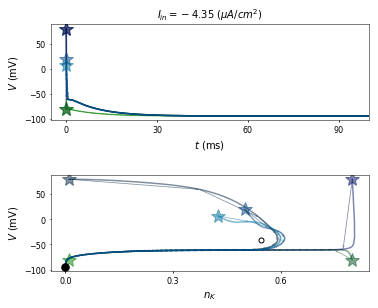

<Figure size 410.4x360 with 0 Axes>

In [ ]:
from matplotlib.pylab import *



ii_iapi=1
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

ii_neuron=0

# ax0.plot(v_results[idx_t],v_results[idx_v][ii_neuron],label='trajectory',color='grey', rasterized=True)
ax0.set_xlabel('$t$ (ms)')
# ax0.set_ylabel('$'+v_one_sim_s[0][idx_v]+'$ (mV)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
# colorii=next(colors)
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')
# ax.set_ylabel('$'+v_one_sim_s[0][idx_v]+'$ (mV)')
ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)


print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()

-2.2522974157999998


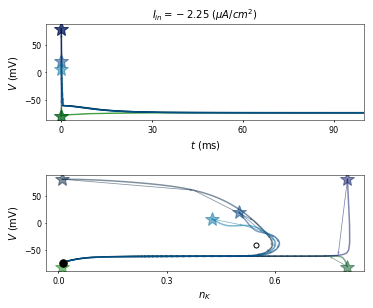

<Figure size 410.4x360 with 0 Axes>

In [ ]:
from matplotlib.pylab import *



ii_iapi=2
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))

for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')

ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)


print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()

-1.5639464195


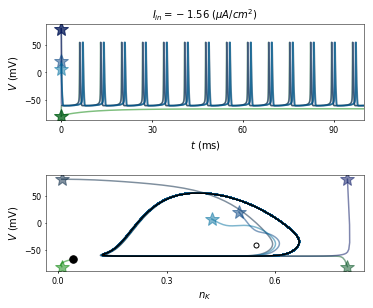

<Figure size 410.4x360 with 0 Axes>

In [ ]:
from matplotlib.pylab import *



ii_iapi=3
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')

ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))
# colorii=next(colors)
for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')

ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)


print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

fig01.show()

In [ ]:
fig_name

'fig_SIM_MTM_W_sPNAs_Temp_snapshot_p0_I_app_-1.5639464195_sigma_0.0'

In [ ]:
from matplotlib.pylab import *



ii_iapi=4
I_app=t_I_app_specf[ii_iapi]


bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
name='SIM_'+model_name+'_'+strIapp+'_'+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]+'_sigma_'+str(sigma_v[0])
f=open(dir_sims_ISI+name+'.pkl', 'rb')
d_save_sim=pickle.load(f)
s_results=d_save_sim['s_results']
v_results=d_save_sim['v_results']
a_spikes_t=d_save_sim['spikes']
M_pars=d_save_sim['pars']
st_limit_cycle=d_save_sim['Dyn_Sys_Properties']['stable_limit_cycle']
st_tau_lc=d_save_sim['Dyn_Sys_Properties']['stable_tau_lc']
uns_limit_cycle=d_save_sim['Dyn_Sys_Properties']['unstable_limit_cycle']
uns_tau_lc=d_save_sim['Dyn_Sys_Properties']['unstable_tau_lc']
saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
stable=d_save_sim['Dyn_Sys_Properties']['stable']


plt.close("all")
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height))
ax0 = plt.subplot2grid((11,6), (0, 0), colspan=6,rowspan=4)
ax = plt.subplot2grid((11,6), (6, 0), colspan=6,rowspan=4)
##############################################################################################################
##### Plot trajectory in phase plane
idx_t=[ii for ii,ii_s in enumerate(s_results) if ii_s=='t'][0]
idx_v=[ii for ii,ii_s in enumerate(s_results) if ii_s=='v'][0]
idx_nk=[ii for ii,ii_s in enumerate(s_results) if ii_s=='n_K'][0]

ii_neuron=0

ax0.set_xlabel('$t$ (ms)')
ax0.set_ylabel('$V$ (mV)')
ax0.set_xlim([v_results[idx_t][0]-5,v_results[idx_t][0]+100])

cmap=plt.get_cmap('ocean_r')
colors=iter(cmap(np.linspace(1,0,num_neurons+3)))

for ii in range(num_neurons):
    colorii=next(colors)
    ax.plot(v_results[idx_nk][ii],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax.quiver(v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_nk][ii][::10][1:]-v_results[idx_nk][ii][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax.plot(v_results[idx_nk][ii][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5, rasterized=True)

    ax0.plot(v_results[idx_t],v_results[idx_v][ii],label='trajectory',color=colorii, alpha=0.5, rasterized=True)
    ax0.quiver(v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][:-1], v_results[idx_t][::10][1:]-v_results[idx_t][::10][:-1], v_results[idx_v][ii][::10][1:]-v_results[idx_v][ii][::10][:-1],color=colorii, alpha=0.5, scale_units='xy', angles='xy', scale=1, rasterized=True)
    ax0.plot(v_results[idx_t][0],v_results[idx_v][ii][0],'*',markersize=15,label='trajectory',color=colorii, alpha=0.5,rasterized=True)

ax.set_xlabel('$'+v_one_sim_s[0][idx_nk]+'$')

ax.set_ylabel('$V$ (mV)')


v_ISI=[]
for spikes_t in a_spikes_t:
    trains=spikes_t
    if len(trains)>2:
        i_isi = np.diff(trains)
        v_ISI.append(i_isi)


try:
    ax.plot(st_limit_cycle[idx_nk],st_limit_cycle[idx_v],label='stable limit cycle',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(uns_limit_cycle[idx_nk],uns_limit_cycle[idx_v],'--',label='unstable limit cycle',color='black', rasterized=True)

except:
    pass
try:
    ax.plot(stable[idx_nk],stable[idx_v],'o',markersize=7.5,label='stable node',color='black', rasterized=True)
except:
    pass
try:
    ax.plot(saddle[idx_nk],saddle[idx_v],'o',markersize=5,mfc='none',label='saddle',color='black', rasterized=True)
except:
    pass

ax0.set_title('$I_{in}='+str(float("{0:.2f}".format(t_I_app_specf[ii_iapi])))+'$ $(\mu A/cm^2)$')

locatory1 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax.yaxis.set_major_locator(locatory1)
locatory2 = MaxNLocator(nbins=3)
ax.xaxis.set_major_locator(locatory2)

locatory10 = MaxNLocator(nbins=4) # with 3 bins you will have 4 ticks
ax0.yaxis.set_major_locator(locatory10)
locatory20 = MaxNLocator(nbins=4)
ax0.xaxis.set_major_locator(locatory20)


print(I_app)


fig_name='fig_'+name

md_dir={}
md_dir['Title']=model_name+' for sigmav='+str(sigma_v)+' and applied current Iapp='+bifpar[strIapp][0][0:bifpar[strIapp][0].index('*')]
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'


fig01.show()

7.6477025842
